%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn import preprocessing, manifold, linear_model, metrics, model_selection, ensemble

In [49]:
data_train = pd.read_csv('./data/house_price/train.csv')
data_test = pd.read_csv('./data/house_price/test.csv')
data_train.head()
data_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [50]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

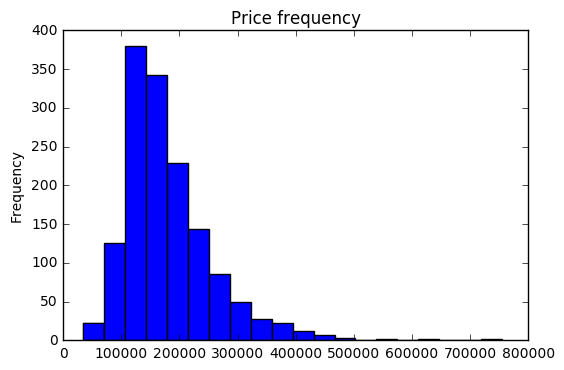

In [51]:
pd.concat([data_train, data_test])['SalePrice'].plot(kind='hist', bins=20, title='Price frequency')

In [52]:
X, y = data_train.iloc[:,1:-1], data_train['SalePrice']
X_test = data_test.iloc[:,1:]

In [53]:
X_all = pd.concat([X, X_test])

# Convert CentralAir to binary feature
X_all['CentralAir'] = X_all['CentralAir'].apply(lambda x: 1 if x=='Y' else 0)

# Convert MSSubClass to categorial feature
X_all['MSSubClass'] = X_all['MSSubClass'].astype(str)

In [45]:
# types of features
binary_features = ['CentralAir']
categorial_features = X_all.select_dtypes(include=[object]).columns.values 
numeric_features = X_all.select_dtypes(exclude=[object]).columns.values
numeric_features = np.delete(numeric_features, np.argwhere(numeric_features=='CentralAir'))

In [46]:
nans = X_all.isnull().sum()
nans = nans[nans > 0]
print nans

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64


In [47]:
# 'MiscFeature' and 'PoolQC' have more than 96% nan values, so we can remove them
to_remove = ['MiscFeature', 'PoolQC']
X_all.drop(to_remove, axis=1, inplace=True)
categorial_features = categorial_features[~np.in1d(categorial_features, to_remove)]

In [55]:
# For following categorial columns change NaN for most frequent values
nan2frequent = ['MasVnrType', 'Electrical', 'MSZoning', 'Utilities']
for column in nan2frequent:
    X_all[column].fillna(X_all[column].value_counts().idxmax(), inplace=True)

# For following categorial columns change NaN for new NA category
nan2new = categorial_features[np.in1d(categorial_features, nan2frequent, invert=True)]
for column in nan2new:
    X_all[column].fillna('NA', inplace=True)

In [56]:
# Numeric features with NaN
nans = X_all[numeric_features].isnull().sum()
nan2numeric = nans[nans > 0].index.values
print(nan2numeric)

['LotFrontage' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF'
 'TotalBsmtSF' 'BsmtFullBath' 'BsmtHalfBath' 'GarageYrBlt' 'GarageCars'
 'GarageArea']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1c97edbed0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f1c97d13f50>]], dtype=object)

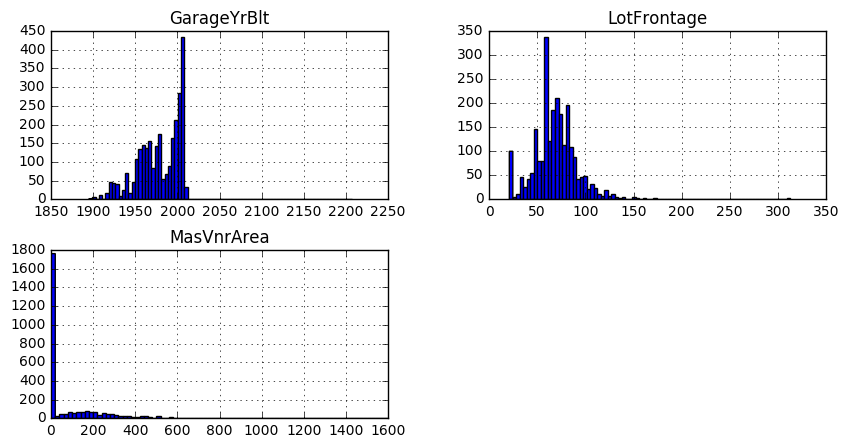

In [58]:
# Let's look on the distribution of numerical features with many NaNs
X_all[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].hist(bins=80, figsize=(10,5))

In [59]:
# Replace NaNs with medians (for mean they are too skewed)
for column in nan2numeric:
    X_all[column].fillna(X_all[column].median(), inplace=True)

In [60]:
# Check that we didn't miss anything
nans = X_all.isnull().sum()
print(nans[nans > 0])

PoolQC         2909
MiscFeature    2814
dtype: int64


NameError: name 'sns' is not defined

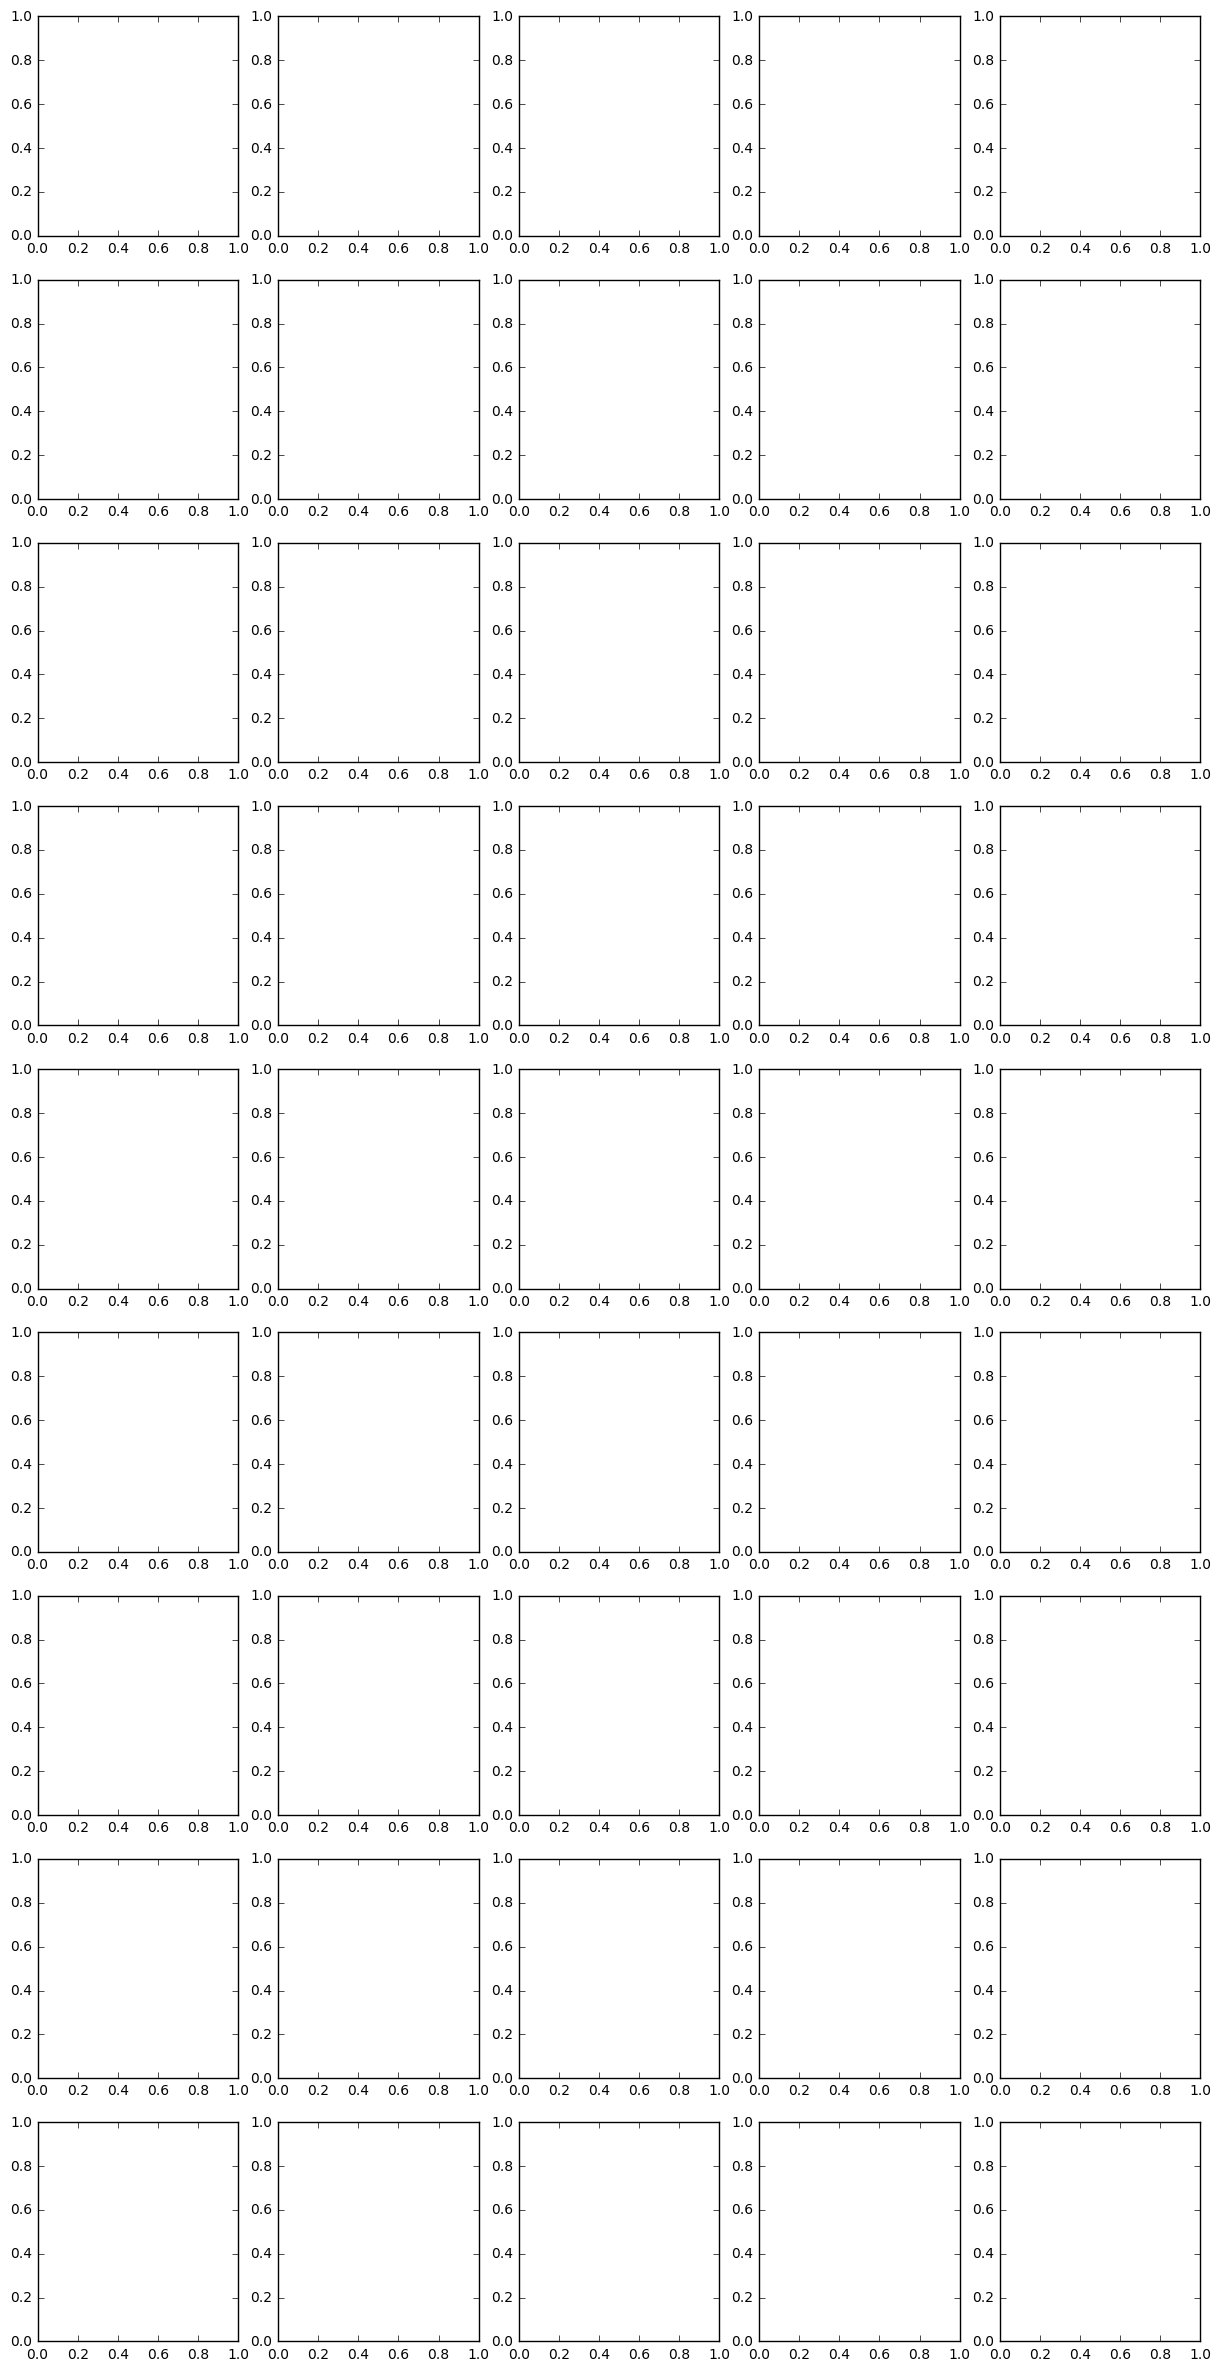

In [61]:
fig, axes = plt.subplots(9, 5, figsize=(15, 30))
for i, feature in enumerate(categorial_features):
    sns.countplot(x=feature, data=X_all, ax=axes[i//5][i%5])

In [62]:
print(X_all['Street'].value_counts())
print(X_all['Utilities'].value_counts())

Pave    2907
Grvl      12
Name: Street, dtype: int64
AllPub    2918
NoSeWa       1
Name: Utilities, dtype: int64
